### Poorly cleaned prototyping and few-shot testing, can be used as a starting point but not documented well...

In [22]:
from datasets import load_dataset, concatenate_datasets
import transformers
from transformers import (
    Trainer,
    TrainingArguments,
    default_data_collator,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    PreTrainedTokenizerFast,
    AutoModelWithLMHead,
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    GPT2TokenizerFast,
    GPT2Model,
    GPT2Config
)
import datasets
import torch
import numpy as np
import os

from evaluate import load

In [23]:

model_type = "finlp"
if model_type == "large":
    tokenizer = AutoTokenizer.from_pretrained("H:\\Data_temp\\checkpoints\\large\\checkpoint-12200")
    model = AutoModelForCausalLM.from_pretrained("H:\\Data_temp\\checkpoints\\large\\checkpoint-12200").to("cuda")
elif model_type == "small":
    tokenizer = AutoTokenizer.from_pretrained(r"H:\Data_temp\checkpoints\small\checkpoint-140000")
    model = AutoModelForCausalLM.from_pretrained(r"H:\Data_temp\checkpoints\small\checkpoint-140000").to("cuda")
elif model_type == "finlp":
    tokenizer = GPT2TokenizerFast.from_pretrained('Finnish-NLP/gpt2-large-finnish')
    model = AutoModelForCausalLM.from_pretrained('Finnish-NLP/gpt2-large-finnish').to("cuda")
elif model_type == "distill":
    config = GPT2Config.from_pretrained(r"H:\Data_temp\checkpoints\distillation\third\config.json")
    tokenizer = AutoTokenizer.from_pretrained(r"H:\Data_temp\checkpoints\large\checkpoint-12200")
    model = AutoModelForCausalLM.from_pretrained(r"H:\Data_temp\checkpoints\distillation\third\model_step_640000.pth",config=config).to("cuda")


In [24]:

fi_annotated_raw = load_dataset("xed_en_fi","fi_annotated")
fi_neutral_raw = load_dataset("xed_en_fi","fi_neutral")

def to_arr(examples):
    labels = []
    for item in examples["labels"]:
        labels.append([item])
    return {"sentence":examples["sentence"],"labels":labels}
fi_neutral_mapped = fi_neutral_raw["train"].map(to_arr, batched=True)

fi_neutral_mapped_cast = fi_neutral_mapped.cast(fi_annotated_raw["train"].features)
dataset = concatenate_datasets([fi_neutral_mapped_cast, fi_annotated_raw["train"]]).shuffle(seed=42)
dataset

Reusing dataset xed_en_fi (H:\Data_temp\cache\xed_en_fi\fi_annotated\1.1.0\da3b85f38c940032e5c051d9afc607f96efc7107ac41104c3ad846dc0ac95d6a)
100%|██████████| 1/1 [00:00<00:00, 222.32it/s]
Reusing dataset xed_en_fi (H:\Data_temp\cache\xed_en_fi\fi_neutral\1.1.0\da3b85f38c940032e5c051d9afc607f96efc7107ac41104c3ad846dc0ac95d6a)
100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]
Loading cached processed dataset at H:\Data_temp\cache\xed_en_fi\fi_neutral\1.1.0\da3b85f38c940032e5c051d9afc607f96efc7107ac41104c3ad846dc0ac95d6a\cache-fb9da1de2b72ad86.arrow
Loading cached processed dataset at H:\Data_temp\cache\xed_en_fi\fi_neutral\1.1.0\da3b85f38c940032e5c051d9afc607f96efc7107ac41104c3ad846dc0ac95d6a\cache-f5d1a6cbf0f317bf.arrow
Loading cached shuffled indices for dataset at H:\Data_temp\cache\xed_en_fi\fi_neutral\1.1.0\da3b85f38c940032e5c051d9afc607f96efc7107ac41104c3ad846dc0ac95d6a\cache-c9a57b3a5a1aebc5.arrow


Dataset({
    features: ['sentence', 'labels'],
    num_rows: 25243
})

In [25]:

labels = {0:"neutraali", 1:"viha", 2:"innokkuus",3:"inho",4:"pelko",5:"ilo",6:"suru",7:"yllättyneisyys",8:"hyväksyntä"}
#{anger:1, anticipation:2, disgust:3, fear:4, joy:5, sadness:6, surprise:7, trust:8, with neutral:0 }

In [26]:
", ".join([labels[item] for item in dataset[1]["labels"]])

'hyväksyntä, ilo'

In [27]:
input = """Perustunteet ovat neutraali, viha, innokkuus, inho, pelko, ilo, suru, yllättyneisyys ja hyväksyntä.
Nimeä perustunteet seuraavista teksteistä:
"""
j = 100
for i in range(3):
    input += "Teksti: " + dataset[j+i]["sentence"] + "\nTunne: " +  ", ".join([labels[item] for item in dataset[j+i]["labels"]]) + "\n"
input += "Teksti: " + dataset[j+3]["sentence"] + "\nTunne: "
print(input)

Perustunteet ovat neutraali, viha, innokkuus, inho, pelko, ilo, suru, yllättyneisyys ja hyväksyntä.
Nimeä perustunteet seuraavista teksteistä:
Teksti: Mary toisin kuin minä on hyvin sivistynyt.
Tunne: ilo
Teksti: Hymy - on suloutta iholla.
Tunne: hyväksyntä, ilo
Teksti: Ovatko kaikki täällä venehulluja?
Tunne: yllättyneisyys
Teksti: Käänny vasemmalle.
Tunne: 


In [28]:
counts = {}
for i in range(9):
    counts[i] = 0

for item in dataset:
    for key in item["labels"]:
        counts[key] += 1
counts
count_sum = 0
for i in range(9):
    count_sum += counts[i]

for i in range(9):
    print(labels[i] ,":" , counts[i]/len(dataset))
print(count_sum/len(dataset))



neutraali : 0.4276036921126649
viha : 0.12664897199223546
innokkuus : 0.09725468446698095
inho : 0.09258012122172483
pelko : 0.08342906944499465
ilo : 0.09578893158499387
suru : 0.08449867289941766
yllättyneisyys : 0.07641722457711049
hyväksyntä : 0.09123321316800698
1.1754545814681299


In [29]:
label_list = []
count_list = []
for i in range(9):
    label_list.append(labels[i])
    count_list.append(100*counts[i]/len(dataset))
label_list, count_list

(['neutraali',
  'viha',
  'innokkuus',
  'inho',
  'pelko',
  'ilo',
  'suru',
  'yllättyneisyys',
  'hyväksyntä'],
 [42.76036921126649,
  12.664897199223548,
  9.725468446698095,
  9.258012122172483,
  8.342906944499465,
  9.578893158499387,
  8.449867289941766,
  7.641722457711048,
  9.123321316800697])

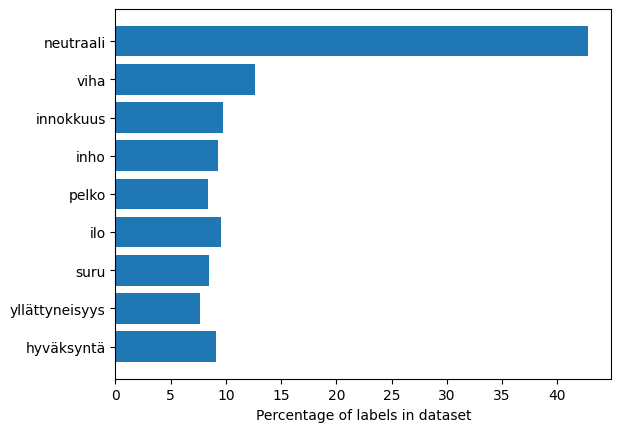

In [30]:
import matplotlib.pyplot as plt
import numpy as np
#labels = {0:"neutraali", 1:"viha", 2:"innokkuus",3:"inho",4:"pelko",5:"ilo",6:"suru",7:"yllättyneisyys",8:"hyväksyntä"}
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(label_list))
performance = count_list

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(label_list)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Percentage of labels in dataset')

plt.show()

In [38]:

input_base = """Perustunteet ovat neutraali, viha, innokkuus, inho, pelko, ilo, suru, yllättyneisyys ja hyväksyntä.
Nimeä perustunteet seuraavista teksteistä:
"""
from tqdm import tqdm
successess = []
in_set = []
all_preds = []
all_targets = []
for s in range(2,3):
    #samples = 5
    samples = s
    runs = len(dataset)//samples
    runs = 5
    start = 0
    print("total runs:",s-1, len(dataset)//samples)
    predictions = []
    targets = []
    model = model.to("cuda")
    for j in tqdm(range(start,start+runs*samples,samples)):
        input_text = input_base
        for i in range(samples-1):
            input_text += "Teksti: " + dataset[j+i]["sentence"] + "\nPerustunne: " +  ", ".join([labels[item] for item in dataset[j+i]["labels"]]) + "\n"
        input_text += "Teksti: " + dataset[j+samples-1]["sentence"] + "\nPerustunne: " 
        target_labels = [labels[item] for item in dataset[j+samples-1]["labels"]]

        #in_tokens = tokenizer(input_text, padding="max_length", truncation=True, max_length=900)
        inputs = tokenizer.encode(input_text, add_special_tokens=False, return_tensors="pt").to("cuda")
        prompt = tokenizer.decode(inputs[0],skip_special_tokens=True, clean_up_tokenization_spaces=True)
        prompt_len = len(prompt)
        #big outputs = model.generate(inputs, max_length=len(inputs[0])+10, do_sample=True, top_p=0.6, top_k=10, temperature=0.1)
        #finnish outputs = model.generate(inputs, max_length=len(inputs[0])+10, do_sample=True, top_p=0.3, top_k=10, temperature=0.4, pad_token_id=tokenizer.eos_token_id)
        if model_type == "custom" or model_type == "distill":
            outputs = model.generate(inputs, max_length=len(inputs[0])+10, do_sample=False, pad_token_id=tokenizer.eos_token_id)
        else:
            outputs = model.generate(inputs, max_length=len(inputs[0])+10, do_sample=False)
        text_out = tokenizer.decode(outputs[0])[prompt_len:]
        print("INPUT:")
        print(input_text)
        print("OUTPUT:")
        print(text_out)
        split = text_out.split()
        prediction = split[0].lower().strip(",.") if len(split) > 0 else ""
        predictions.append(prediction)
        targets.append(target_labels)
        #print(j,prediction in target_labels, "PRED:", prediction, "LABELS:" , ",".join(target_labels),"TEXT:", dataset[j+samples-1]["sentence"])
    success = 0
    in_labels = 0
    total = len(predictions)
    for i in range(total):
        success += 1 if predictions[i] in targets[i] else 0
        in_labels += 1 if predictions[i] in label_list else 0
    successess.append(success/total)
    in_set.append(in_labels/total)
    all_preds.append(predictions)
    all_targets.append(targets)
#len(tokenizer.decode(first,skip_special_tokens=True, clean_up_tokenization_spaces=True))
successess, in_set

total runs: 1 12621


 20%|██        | 1/5 [00:00<00:01,  2.45it/s]

INPUT:
Perustunteet ovat neutraali, viha, innokkuus, inho, pelko, ilo, suru, yllättyneisyys ja hyväksyntä.
Nimeä perustunteet seuraavista teksteistä:
Teksti: Näen joukon ihmisiä kolmannessa kerroksessa.
Perustunne: neutraali
Teksti: Kaikki hyvin.
Perustunne: 
OUTPUT:
ännän ja emännän välinen suhde on hyvin läheinen


 40%|████      | 2/5 [00:00<00:01,  2.74it/s]

INPUT:
Perustunteet ovat neutraali, viha, innokkuus, inho, pelko, ilo, suru, yllättyneisyys ja hyväksyntä.
Nimeä perustunteet seuraavista teksteistä:
Teksti: Se oli kamalan hankala.
Perustunne: viha
Teksti: Seitsemän vuodenko?
Perustunne: 
OUTPUT:
ännän kanssa. Perustunne: änn


 60%|██████    | 3/5 [00:01<00:00,  2.88it/s]

INPUT:
Perustunteet ovat neutraali, viha, innokkuus, inho, pelko, ilo, suru, yllättyneisyys ja hyväksyntä.
Nimeä perustunteet seuraavista teksteistä:
Teksti: Mitä haluaisit tietää?
Perustunne: yllättyneisyys
Teksti: En vain uskonut korviani.
Perustunne: 
OUTPUT:
ännän ja emännän välinen suhde on kahden aikuisen


 80%|████████  | 4/5 [00:01<00:00,  2.94it/s]

INPUT:
Perustunteet ovat neutraali, viha, innokkuus, inho, pelko, ilo, suru, yllättyneisyys ja hyväksyntä.
Nimeä perustunteet seuraavista teksteistä:
Teksti: Olen varma, että tunnet samoin minua kohtaan, joten pysytään erossa toisistamme.
Perustunne: suru
Teksti: Hyvää peliä, kaverit.
Perustunne: 
OUTPUT:
ännän ja emännän välinen suhde on kahden aikuisen


100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

INPUT:
Perustunteet ovat neutraali, viha, innokkuus, inho, pelko, ilo, suru, yllättyneisyys ja hyväksyntä.
Nimeä perustunteet seuraavista teksteistä:
Teksti: Myyn yrityksen pieninä osina koska osat ovat kokonaisuutta arvokkaampia.
Perustunne: neutraali
Teksti: En anna kenenkään tytön sitoa itseäni.
Perustunne: 
OUTPUT:
ivaALLINENLLYS: ivallinenLLYS: 


([0.0], [0.0])

In [27]:
import pickle
with open('preds.pickle', 'wb') as handle:
    pickle.dump(all_preds, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('targets.pickle', 'wb') as handle:
    pickle.dump(all_targets, handle, protocol=pickle.HIGHEST_PROTOCOL)

"small"
([0.00225805173711524,
  0.15870374772205056,
  0.15711908723555978,
  0.19270998415213947,
  0.22801109350237717,
  0.2267649156168291,
  0.24708818635607321,
  0.24532488114104595,
  0.26212553495007135],
 [0.009428356376025036,
  0.5837096901988749,
  0.5331590206798194,
  0.6407290015847861,
  0.6988906497622821,
  0.7314000475398146,
  0.7742651136993899,
  0.803486529318542,
  0.8184736091298146])

"distill"
([0.0,
  0.20917518421678155,
  0.2300927026384597,
  0.24532488114104595,
  0.25614104595879555,
  0.24815783218445447,
  0.24126455906821964,
  0.23264659270998414,
  0.23359486447931527],
 [0.0,
  0.7923302432453847,
  0.8159020679819349,
  0.8706814580031695,
  0.8629160063391442,
  0.8604706441644877,
  0.8394342762063228,
  0.8256735340729001,
  0.8113409415121255])

"custom"
([0.007051459810640573,
  0.01758973140004754,
  0.024720703589256002,
  0.030903328050713153,
  0.034270998415213944,
  0.03636795816496316,
  0.03937881308929562,
  0.04469096671949287,
  0.039229671897289584],
 [0.054549776175573425,
  0.12621820774898979,
  0.18564297599239363,
  0.22472266244057051,
  0.2662440570522979,
  0.281198003327787,
  0.30282861896838603,
  0.3033280507131537,
  0.2970756062767475])

"large"
([0.0,
  0.23944219950875525,
  0.1743522700261469,
  0.20839936608557844,
  0.21196513470681458,
  0.2053719990492037,
  0.21075984470327233,
  0.19904912836767036,
  0.19721825962910128],
 [7.922988551281543e-05,
  0.9805086760161635,
  0.9628000950796292,
  0.9725832012678288,
  0.9756339144215531,
  0.9800332778702163,
  0.9836383804769828,
  0.9870047543581616,
  0.9853780313837375])

In [ ]:

input_base = """Perustunteet ovat neutraali, viha, innokkuus, inho, pelko, ilo, suru, yllättyneisyys ja hyväksyntä.
Nimeä perustunteet seuraavista teksteistä:
"""
from tqdm import tqdm
successess = []
in_set = []
for s in range(1,10):
    #samples = 5
    samples = s
    runs = len(dataset)//samples
    #runs = 100
    start = 0
    print("total runs:",s-1, len(dataset)//samples)
    predictions = []
    targets = []
    model = model.to("cuda")
    for j in tqdm(range(start,start+runs*samples,samples)):
        input_text = input_base
        for i in range(samples-1):
            input_text += "Teksti: " + dataset[j+i]["sentence"] + "\nPerustunne: " +  ", ".join([labels[item] for item in dataset[j+i]["labels"]]) + "\n"
        input_text += "Teksti: " + dataset[j+samples-1]["sentence"] + "\nPerustunne:" 
        target_labels = [labels[item] for item in dataset[j+samples-1]["labels"]]

        #in_tokens = tokenizer(input_text, padding="max_length", truncation=True, max_length=900)
        inputs = tokenizer.encode(input_text, add_special_tokens=False, return_tensors="pt").to("cuda")
        prompt = tokenizer.decode(inputs[0],skip_special_tokens=True, clean_up_tokenization_spaces=True)
        prompt_len = len(prompt)
        #big outputs = model.generate(inputs, max_length=len(inputs[0])+10, do_sample=True, top_p=0.6, top_k=10, temperature=0.1)
        #finnish outputs = model.generate(inputs, max_length=len(inputs[0])+10, do_sample=True, top_p=0.3, top_k=10, temperature=0.4, pad_token_id=tokenizer.eos_token_id)
        if model_type == "custom":
            #outputs = model.generate(inputs, max_length=len(inputs[0])+10, do_sample=True, top_p=0.3, top_k=10, temperature=0.4, pad_token_id=tokenizer.eos_token_id)
            outputs = model.generate(inputs, max_length=len(inputs[0])+10, do_sample=False, pad_token_id=tokenizer.eos_token_id)
        elif model_type == "distill":
            outputs = model.generate(inputs, max_length=len(inputs[0])+10, do_sample=True, top_p=0.3, top_k=10, temperature=0.4, pad_token_id=tokenizer.eos_token_id)
        elif model_type == "large":
            #outputs = model.generate(inputs, max_length=len(inputs[0])+10, do_sample=True, top_p=0.2, top_k=10, temperature=0.4) 0.22
            outputs = model.generate(inputs, max_length=len(inputs[0])+10, do_sample=True, top_p=0.3, top_k=5, temperature=0.1)
            outputs = model.generate(inputs, max_length=len(inputs[0])+10, do_sample=False)
        else:
            outputs = model.generate(inputs, max_length=len(inputs[0])+10, do_sample=True, top_p=0.6, top_k=10, temperature=0.1)
        text_out = tokenizer.decode(outputs[0])[prompt_len:]
        #print("INPUT:")
        #print(prompt)
        #print("OUTPUT:")
        #print(text_out)

        prediction = text_out.split()[0].lower().strip(",.")
        predictions.append(prediction)
        targets.append(target_labels)
        #print(j,prediction in target_labels, "PRED:", prediction, "LABELS:" , ",".join(target_labels),"TEXT:", dataset[j+samples-1]["sentence"])
    success = 0
    in_labels = 0
    total = len(predictions)
    for i in range(total):
        success += 1 if predictions[i] in targets[i] else 0
        in_labels += 1 if predictions[i] in label_list else 0
    successess.append(success/total)
    in_set.append(in_labels/total)
#len(tokenizer.decode(first,skip_special_tokens=True, clean_up_tokenization_spaces=True))
successess, in_set

"small"
([0.0022976666798716476,
  0.15767371840583155,
  0.15711908723555978,
  0.19397781299524564,
  0.22880348652931853,
  0.225576420251961,
  0.24708818635607321,
  0.24564183835182252,
  0.2624821683309558],
 [0.009666046032563482,
  0.5812534664448142,
  0.5332778702163061,
  0.6404120443740096,
  0.6996830427892234,
  0.7304492512479202,
  0.7737104825291181,
  0.8053882725832012,
  0.8199001426533523])

"large"

([0.0,
  0.23904603438713257,
  0.17233182790587118,
  0.20649762282091919,
  0.21097464342313788,
  0.2053719990492037,
  0.2129783693843594,
  0.20126782884310618,
  0.19686162624821682],
 [7.922988551281543e-05,
  0.9801125108945409,
  0.9638697409080105,
  0.9708399366085578,
  0.9750396196513471,
  0.9809840741621108,
  0.9836383804769828,
  0.9882725832012679,
  0.9843081312410842])

Text(0, 0.5, 'Accuracy')

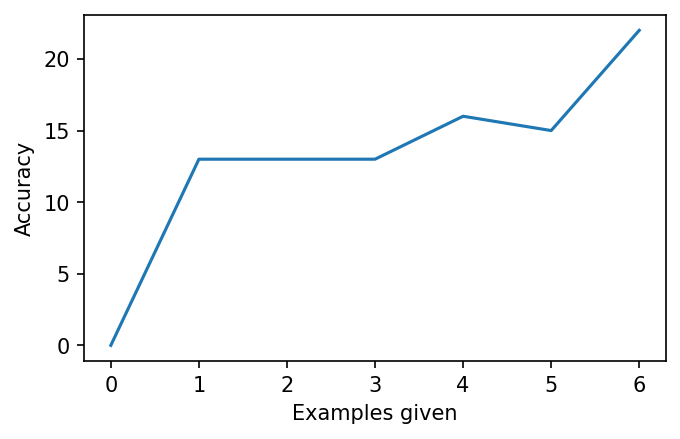

In [16]:
tries = np.array(range(1,8))-1
accuracy = np.array(successess)*100
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
ax.plot(tries,accuracy)
ax.set_xlabel("Examples given")
ax.set_ylabel("Accuracy")


Text(0, 0.5, 'percentage in labels')

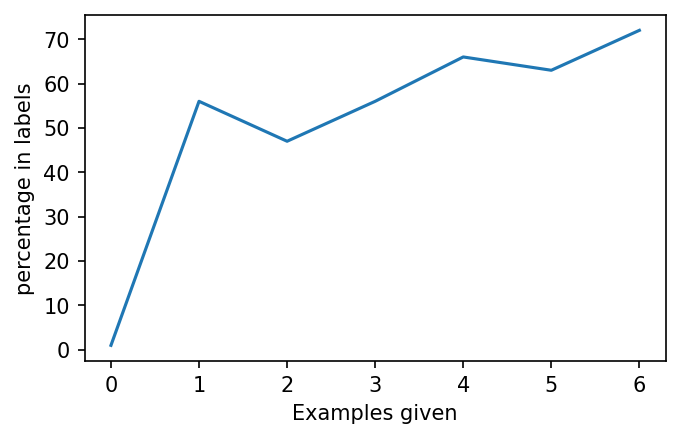

In [17]:
tries = np.array(range(1,8))-1
accuracy = np.array(in_set)*100
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
ax.plot(tries,accuracy)
ax.set_xlabel("Examples given")
ax.set_ylabel("percentage of generations in label set")

In [24]:
success = 0
in_labels = 0
total = len(predictions)
for i in range(total):
    success += 1 if predictions[i] in targets[i] else 0
    in_labels += 1 if predictions[i] in label_list else 0
print(success/total, in_labels/total)

0.18 0.96


In [ ]:
import pickle
with open('preds.pickle', 'wb') as handle:
    pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('targets.pickle', 'wb') as handle:
    pickle.dump(targets, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
preds_load = None
refs_load = None
with open('preds.pickle', 'rb') as handle:
    preds_load = pickle.load(handle)
with open('refs.pickle', 'rb') as handle:
    refs_load = pickle.load(handle)

In [73]:
np.array(success).sum()/len(success)

0.13186813186813187

In [63]:
target_labels

['inho']

In [55]:
outputs.split()[0]


tensor([[45742,   275,    26, 24750, 22160,  1655, 46957, 38494,    14,   182,
         30257, 28643,    26, 35724,   182, 45742,   275,    26,  2054,   797,
            14,   182, 30257, 28643,    26, 49176,    12,  6190,   182, 45742,
           275,    26,   775,   458, 20980,  7391,    14,   182, 30257, 28643,
            26,  6543,   182, 45742,   275,    26, 45117,  1348,   290,    31,
           182, 30257, 28643,    26, 35724,   182, 45742,   275,    26,  1225,
         13614,  1304,    31,   182, 30257, 28643,    26,  1703,  9636,   384,
          3388,   182, 45742,   275,    26,   693,   525, 10253, 36945,   882,
            14,   182, 30257, 28643,    26,   693,  1032,    14,   182, 45742,
           275,    26,  1069, 17974,    14]])

In [33]:
dataset[j+step-1]

{'sentence': 'Seitsemän vuodenko?', 'labels': [0]}